In [1]:
import gym
import numpy as np
import pygame
from gym import spaces
from pygame.locals import *
import matplotlib.pyplot as plt

# Constants for the game
SCREEN_WIDTH = 288
SCREEN_HEIGHT = 512
FPS = 60
BIRD_WIDTH, BIRD_HEIGHT = 34, 24
MONSTER_WIDTH, MONSTER_HEIGHT = 40, 40  # Monster's size

# Define the FlappyBirdWithMonsterEnv Class
class FlappyBirdWithMonsterEnv(gym.Env):
    def __init__(self):
        super(FlappyBirdWithMonsterEnv, self).__init__()

        # Action Space: 0 = Do nothing, 1 = Flap
        self.action_space = spaces.Discrete(2)

        # Observation Space: Screen dimensions (width, height, 3 channels for RGB)
        self.observation_space = spaces.Box(low=0, high=255, shape=(SCREEN_HEIGHT, SCREEN_WIDTH, 3), dtype=np.uint8)

        # Initialize Pygame
        pygame.init()

        # Create the screen object and set the caption
        self.screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
        pygame.display.set_caption("Flappy Bird with Monster")
        
        # Define game variables
        self.bird = None
        self.bird_x = SCREEN_WIDTH // 4
        self.bird_y = SCREEN_HEIGHT // 2
        self.bird_velocity = 0
        self.gravity = 0.25
        self.lift = -5
        self.pipes = []
        self.pipe_width = 50
        self.pipe_gap = 150
        self.pipe_velocity = 4
        self.score = 0
        self.monster = None  # Initially no monster
        self.monster_x = None
        self.monster_y = None

        self.clock = pygame.time.Clock()

    def reset(self):
        # Reset bird and game state
        self.bird_y = SCREEN_HEIGHT // 2
        self.bird_velocity = 0
        self.pipes = []
        self.score = 0
        self.monster = None  # No monster at the start
        self.monster_x = None
        self.monster_y = None
        self.create_pipe()
        return self.get_state()

    def get_state(self):
        # Returns the current screen as the state
        state = pygame.surfarray.array3d(pygame.display.get_surface())
        # Transpose the state to (height, width, channels)
        state = np.transpose(state, (1, 0, 2))  # Swap width and height axes
        return state

    def create_pipe(self):
        # Position pipes randomly in the middle of the screen with a gap for the bird to pass
        gap_y = np.random.randint(100, SCREEN_HEIGHT - self.pipe_gap - 100)  # Random gap for bird to pass
        pipe_x = np.random.randint(SCREEN_WIDTH // 2, SCREEN_WIDTH)  # Random horizontal position for pipes within the screen
        top_rect = pygame.Rect(pipe_x, 0, self.pipe_width, gap_y)  # Top pipe starts at the top
        bottom_rect = pygame.Rect(pipe_x, gap_y + self.pipe_gap, self.pipe_width, SCREEN_HEIGHT - gap_y - self.pipe_gap)  # Bottom pipe
        self.pipes.append((top_rect, bottom_rect))

        # Debugging: Print the pipe positions
        print(f"Created pipe at x={pipe_x}, top_rect.y={gap_y}, bottom_rect.y={gap_y + self.pipe_gap}")

    def step(self, action):
        # Handle events
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                quit()

        # Action: 0 = Do nothing, 1 = Flap
        if action == 1:
            self.bird_velocity = self.lift

        # Update bird's velocity and position
        self.bird_velocity += self.gravity
        self.bird_y += self.bird_velocity

        # Check for collisions with the ceiling and ground
        if self.bird_y < 0 or self.bird_y > SCREEN_HEIGHT:
            return self.get_state(), -1, True, {}

        # Move pipes and check for collisions
        reward = 0
        for top_rect, bottom_rect in self.pipes:
            top_rect.x -= self.pipe_velocity
            bottom_rect.x -= self.pipe_velocity

            # Debugging: Print pipe x position while moving
            print(f"Moving pipe at x={top_rect.x}, bottom_rect.x={bottom_rect.x}")

            if top_rect.right < 0:
                self.pipes.remove((top_rect, bottom_rect))
                self.create_pipe()
                self.score += 1
                reward = 1  # Reward for passing a pipe

            # Check for collision with pipes
            if top_rect.colliderect(pygame.Rect(self.bird_x, self.bird_y, BIRD_WIDTH, BIRD_HEIGHT)) or bottom_rect.colliderect(pygame.Rect(self.bird_x, self.bird_y, BIRD_WIDTH, BIRD_HEIGHT)):
                return self.get_state(), -1, True, {}

        # If the bird has failed, spawn the monster
        if self.monster is None:
            self.monster_x = SCREEN_WIDTH // 2
            self.monster_y = np.random.randint(0, SCREEN_HEIGHT)
            self.monster = pygame.Rect(self.monster_x, self.monster_y, MONSTER_WIDTH, MONSTER_HEIGHT)

        # Move the monster toward the bird
        if self.monster is not None:
            self.monster.x -= 2  # Monster moves towards the bird
            if self.monster.x < self.bird_x + BIRD_WIDTH and self.monster.colliderect(pygame.Rect(self.bird_x, self.bird_y, BIRD_WIDTH, BIRD_HEIGHT)):
                return self.get_state(), -10, True, {"message": "Monster caught the bird!"}

        # Draw everything
        self.screen.fill((0, 0, 0))  # Black background
        pygame.draw.rect(self.screen, (255, 0, 0), (self.bird_x, self.bird_y, BIRD_WIDTH, BIRD_HEIGHT))  # Bird

        # Drawing the pipes
        for top_rect, bottom_rect in self.pipes:
            pygame.draw.rect(self.screen, (0, 255, 0), top_rect)  # Top pipe
            pygame.draw.rect(self.screen, (0, 255, 0), bottom_rect)  # Bottom pipe

        # Draw the monster if it exists
        if self.monster is not None:
            pygame.draw.rect(self.screen, (0, 0, 255), self.monster)  # Monster

        pygame.display.update()
        self.clock.tick(FPS)

        return self.get_state(), reward, False, {}

    def render(self):
        pygame.display.flip()

    def close(self):
        pygame.quit()


Created pipe at x=157, top_rect.y=225, bottom_rect.y=375
Moving pipe at x=153, bottom_rect.x=153


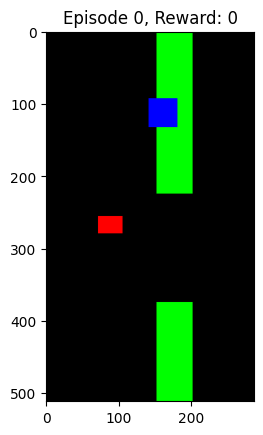

Debugging: Episode 0
Moving pipe at x=149, bottom_rect.x=149
Moving pipe at x=145, bottom_rect.x=145
Moving pipe at x=141, bottom_rect.x=141
Moving pipe at x=137, bottom_rect.x=137
Moving pipe at x=133, bottom_rect.x=133
Moving pipe at x=129, bottom_rect.x=129
Moving pipe at x=125, bottom_rect.x=125
Moving pipe at x=121, bottom_rect.x=121
Moving pipe at x=117, bottom_rect.x=117
Moving pipe at x=113, bottom_rect.x=113
Moving pipe at x=109, bottom_rect.x=109
Moving pipe at x=105, bottom_rect.x=105
Game Over! Info: {}


In [2]:
# Create the environment
env = FlappyBirdWithMonsterEnv()

# Reset the environment to start a new game
state = env.reset()

# Run random actions to see the environment in action
for _ in range(1000):
    action = env.action_space.sample()  # Random action: flap or do nothing
    state, reward, done, info = env.step(action)  # Apply the action to the environment

    # Display the environment after action
    if _ % 50 == 0:  # Display every 50 steps
        plt.imshow(state)
        plt.title(f'Episode {_}, Reward: {reward}')
        plt.show()

    # Print debugging info every 50 steps to check pipe creation and movement
    if _ % 50 == 0:
        print(f"Debugging: Episode {_}")
    
    if done:
        print(f"Game Over! Info: {info}")
        break

env.close()


### Flappy Bird with Monster Environment
#### This custom Flappy Bird with Monster environment is built using reinforcement learning principles, where the agent (the bird) tries to navigate through obstacles (pipes) while avoiding getting caught by a monster.

#### Key Features of the Environment:
#### Bird (Red Square): The bird is controlled by the agent. The bird’s movement is influenced by gravity and the flap action. The flap moves the bird upwards, and gravity pulls it downward.

#### Monster (Blue Square): After the bird fails (e.g., by colliding with pipes or the ground), a monster spawns at a random position and moves toward the bird. If the monster catches the bird, the game ends with a penalty.

#### Pipes (Green Rectangles): Pipes are randomly generated with a gap for the bird to fly through. The pipes start from the right side of the screen and move leftward. The goal is to navigate through the gap without hitting the pipes or the ground.

#### Game Flow:
#### Start: The game begins with the bird positioned in the middle of the screen.

#### Pipes Generation: The pipes are generated randomly along the screen, and the bird must navigate through the gap.

#### Monster Activation: If the bird fails, a monster appears and moves toward the bird. If the bird is caught by the monster, the game ends.

#### Reward System: The agent receives rewards for passing through the pipes and penalties for collisions with the pipes, the ground, or being caught by the monster.

#### Observations and Actions:
#### Observation: The environment returns an image of the screen, which includes the bird, pipes, and monster. This image serves as the state that the agent can use to make decisions.

#### Actions: The agent can take two actions:

#### 0: Do nothing (gravity affects the bird).

#### 1: Flap (move the bird upward).

#### Screenshot Description:
#### The provided screenshot shows:

#### The bird (red square) positioned near the bottom of the screen.

#### The monster (blue square) is in the lower-middle area of the screen, and it moves towards the bird.

#### Green pipes are positioned across the screen, with a gap for the bird to fly through.

#### This environment serves as a great starting point for testing reinforcement learning algorithms, particularly when trying to train an agent to make decisions based on visual input (image-based state representation). The added monster introduces an additional layer of complexity, making the environment more dynamic and challenging.



### defining the deep Q-Network Algorithm

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 128)  # Second hidden layer
        self.fc3 = nn.Linear(128, output_dim)  # Output layer (Q-values for all actions)

    def forward(self, state):
        x = F.relu(self.fc1(state))  # Apply ReLU activation
        x = F.relu(self.fc2(x))  # Apply ReLU activation
        return self.fc3(x)  # Return Q-values for each action


In [4]:
import random
import numpy as np
from collections import deque

class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.1, batch_size=64, memory_size=10000, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration factor
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)  # Experience replay memory
        self.learning_rate = learning_rate

        # Create the Q-network and target network
        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())  # Initialize target network with the Q-network weights

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)

    def remember(self, state, action, reward, next_state, done):
        # Store the experience in memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore: random action

        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).view(1, -1)  # Flatten state
        q_values = self.q_network(state_tensor)  # Get Q-values for all actions
        return torch.argmax(q_values).item()  # Exploit: action with highest Q-value

    def replay(self):
        if len(self.memory) < self.batch_size:
            return  # Not enough experience in memory to sample

        # Sample a batch of experiences from memory
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors and flatten the states
        states = torch.tensor(states, dtype=torch.float32).view(self.batch_size, -1)  # Flatten states
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32).view(self.batch_size, -1)  # Flatten next states
        dones = torch.tensor(dones, dtype=torch.float32)

        # Get the current Q-values from the Q-network
        q_values = self.q_network(states)
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)  # Q-value for the chosen action

        # Get the target Q-values from the target network
        target_q_values = self.target_network(next_states)
        target_q_values = target_q_values.max(1)[0]  # Maximum Q-value for the next state (Bellman equation)

        # Update the target Q-value
        targets = rewards + (self.gamma * target_q_values * (1 - dones))  # Bellman equation

        # Loss (Mean Squared Error between predicted Q-values and target Q-values)
        loss = F.mse_loss(q_values, targets)

        # Optimize the Q-network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon for exploration
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        # Periodically copy Q-network weights to the target network
        self.target_network.load_state_dict(self.q_network.state_dict())


In [5]:
def train_dqn(env, agent, episodes=100, max_timesteps=500):
    for episode in range(episodes):  # Ensure episodes are set to 100
        state = env.reset()
        state = np.reshape(state, [1, agent.state_size])  # Reshape state
        total_reward = 0

        for t in range(max_timesteps):
            action = agent.act(state)  # Choose action using epsilon-greedy strategy
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, agent.state_size])  # Reshape next state

            agent.remember(state, action, reward, next_state, done)  # Store experience
            state = next_state
            total_reward += reward

            if len(agent.memory) > agent.batch_size:  # Train only if enough samples are collected
                agent.replay()  # Train agent on experiences in memory

            if done:
                break

        if episode % 10 == 0:  # Update target network every 10 episodes
            agent.update_target_network()

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return agent


In [6]:
def test_agent(env, agent, episodes=10):
    # Set epsilon to 0 for testing (no exploration, always exploit learned policy)
    agent.epsilon = 0.0
    
    for episode in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, agent.state_size])  # Reshape state
        total_reward = 0

        for t in range(500):  # Maximum number of timesteps
            action = agent.act(state)  # Choose action using the trained Q-network
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, agent.state_size])  # Reshape next state

            state = next_state
            total_reward += reward

            if done:
                break

        print(f"Test Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")


In [ ]:
# Set up the environment
env = FlappyBirdWithMonsterEnv()  # Your custom Flappy Bird with Monster environment

# Initialize the DQN agent
state_size = SCREEN_HEIGHT * SCREEN_WIDTH * 3  # Flattening the state to match image dimensions
action_size = env.action_space.n  # Number of actions
agent = DQNAgent(state_size, action_size)

# Train the agent
trained_agent = train_dqn(env, agent)

# Test the trained agent
test_agent(env, trained_agent)


Created pipe at x=192, top_rect.y=108, bottom_rect.y=258
Moving pipe at x=188, bottom_rect.x=188
Moving pipe at x=184, bottom_rect.x=184
Moving pipe at x=180, bottom_rect.x=180
Moving pipe at x=176, bottom_rect.x=176
Moving pipe at x=172, bottom_rect.x=172
Moving pipe at x=168, bottom_rect.x=168
Moving pipe at x=164, bottom_rect.x=164
Moving pipe at x=160, bottom_rect.x=160
Moving pipe at x=156, bottom_rect.x=156
Moving pipe at x=152, bottom_rect.x=152
Moving pipe at x=148, bottom_rect.x=148
Moving pipe at x=144, bottom_rect.x=144
Moving pipe at x=140, bottom_rect.x=140
Moving pipe at x=136, bottom_rect.x=136
Moving pipe at x=132, bottom_rect.x=132
Moving pipe at x=128, bottom_rect.x=128
Moving pipe at x=124, bottom_rect.x=124
Moving pipe at x=120, bottom_rect.x=120
Moving pipe at x=116, bottom_rect.x=116
Moving pipe at x=112, bottom_rect.x=112
Moving pipe at x=108, bottom_rect.x=108
Moving pipe at x=104, bottom_rect.x=104
Moving pipe at x=100, bottom_rect.x=100
Moving pipe at x=96, bo

C:\Users\PC\AppData\Local\Temp\ipykernel_8240\343911444.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states = torch.tensor(states, dtype=torch.float32).view(self.batch_size, -1)  # Flatten states


Moving pipe at x=189, bottom_rect.x=189
Moving pipe at x=185, bottom_rect.x=185
Moving pipe at x=181, bottom_rect.x=181
Moving pipe at x=177, bottom_rect.x=177
Moving pipe at x=173, bottom_rect.x=173
Moving pipe at x=169, bottom_rect.x=169
Moving pipe at x=165, bottom_rect.x=165
Moving pipe at x=161, bottom_rect.x=161
Moving pipe at x=157, bottom_rect.x=157
Moving pipe at x=153, bottom_rect.x=153
Moving pipe at x=149, bottom_rect.x=149
Moving pipe at x=145, bottom_rect.x=145
Moving pipe at x=141, bottom_rect.x=141
Moving pipe at x=137, bottom_rect.x=137
Moving pipe at x=133, bottom_rect.x=133
Moving pipe at x=129, bottom_rect.x=129
Moving pipe at x=125, bottom_rect.x=125
Moving pipe at x=121, bottom_rect.x=121
Moving pipe at x=117, bottom_rect.x=117
Moving pipe at x=113, bottom_rect.x=113
Moving pipe at x=109, bottom_rect.x=109
Moving pipe at x=105, bottom_rect.x=105
Episode 3/100, Total Reward: -1, Epsilon: 0.8911090557802088
Created pipe at x=229, top_rect.y=131, bottom_rect.y=281
Mo

: 